In [12]:
import os
import sys

In [2]:
direct='../'
exec(open('../LoadData.py').read())
exec(open('ChoiceMaker.py').read())
exec(open('Algorithms.py').read())

In [3]:
from dpcomp_core.algorithm import *
from dpcomp_core.query_nd_union import ndRangeUnion
from dpcomp_core import workload


In [4]:
def get_hist(col, epsilon, seed):
    cnts = pd.value_counts(col)
    h_maker = identity.identity_engine()
    Q = workload.Identity((len(cnts.index),))
    cnts = h_maker.Run(Q, cnts, epsilon, seed)
    cnts /= cnts.sum()
    return cnts
    
def rand_seed(seed):
    prng = np.random.RandomState(seed)
    while(True):
        yield prng.randint(0, 2**32)
        
def DPNaiveBayes(db, budget, seed=12345, ret_preds=False):
    k = len(db.x_names)
    epsilon = budget/(k+1)
    ys = db.train[db.y_name]
    ycat = db.train[db.y_name].cat.categories
    rand_int = rand_seed(seed)
    
    Hy = get_hist(db.train[db.y_name], epsilon, next(rand_int))
    Hxs = dict([(c, dict([(y, get_hist(db.train[ys==y][c], epsilon, next(rand_int))) for y in ycat])) for c in db.x_names])
    probs = np.array([np.array([Hxs[c][y][db.test[c]] for c in db.x_names]).prod(axis=0)*Hy[y] for y in ycat]).T
    preds = probs.argmax(axis=1)
    acc = (preds == db.test[db.y_name]).sum() / len(db.test)
    if(ret_preds):
        return acc, preds
    else:
        return acc
    

In [5]:
DPNaiveBayes(nurs, 20, 1245)

0.8899176954732511

In [97]:
import pickle
alg_list = [Dawa(), Identity(), Hb()]
MF = HistMetafeats()
d = DTree(3, group_gini)
mf_eval = pickle.load(open('mf_eval.p', 'rb'))
alg_perfs = pickle.load(open('alg_perfs.p', 'rb'))
cm = ChoiceMaker(MF, alg_list, mf_eval, alg_perfs, d)
#cm = ChoiceMaker.create_regret_based(train_set, alg_list, d, MF)

In [8]:
def get_hist(col, epsilon, cm, seed):
    cnts = pd.value_counts(col)
    i = cnts.index
    cnts = np.around(cnts/epsilon).astype(int)
    Q = workload.Identity((len(i),))
    D = Data(cnts, len(col.cat.categories), len(col), False, 1.0)
    
    #h_maker = identity.identity_engine()
    #cnts = h_maker.Run(Q, cnts, 1.0, seed)
    noisy_cnts = pd.Series(cm.mkChoice(D), index=i)
    noisy_cnts /= noisy_cnts.sum()
    return noisy_cnts
def DPNaiveBayes(db, budget, cm, seed=12345, ret_preds=False):
    k = len(db.x_names)
    epsilon = budget/(k+1)
    ys = db.train[db.y_name]
    ycat = db.train[db.y_name].cat.categories
    rand_int = rand_seed(seed)
    
    Hy = get_hist(db.train[db.y_name], epsilon, cm, next(rand_int))
    Hxs = dict([(c, dict([(y, get_hist(db.train[ys==y][c], epsilon, cm, next(rand_int))) for y in ycat])) for c in db.x_names])
    probs = np.array([np.array([Hxs[c][y][db.test[c]] for c in db.x_names]).prod(axis=0)*Hy[y] for y in ycat]).T
    preds = probs.argmax(axis=1)
    acc = (preds == db.test[db.y_name]).sum() / len(db.test)
    if(ret_preds):
        return acc, preds
    else:
        return acc

In [9]:
class MF_null:
    @staticmethod
    def eval(db):
        return None

class Const_Pred:
    def __init__(self, pred):
        self.pred = pred
    @staticmethod
    def fit(X, y):
        pass
    def predict(self, X):
        return self.pred

ID_CM = ChoiceMaker(MF_null, alg_list, [], [], Const_Pred('Id'))
DAWA_CM = ChoiceMaker(MF_null, alg_list, [], [], Const_Pred('DAWA'))
HB_CM = ChoiceMaker(MF_null, alg_list, [], [], Const_Pred('Hb'))

In [69]:
s = rand_seed(12345)
A1 = np.array([DPNaiveBayes(nurs, 20, ID_CM, next(s)) for x in range(0, 100)])

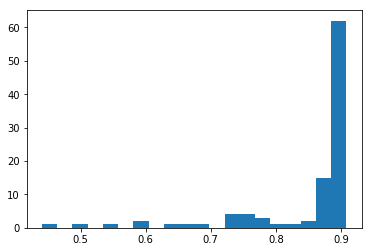

In [70]:
_ = plt.hist(A1, bins=20)

In [71]:
A2 = np.array([DPNaiveBayes(nurs, 20, DAWA_CM, next(s)) for x in range(0, 100)])

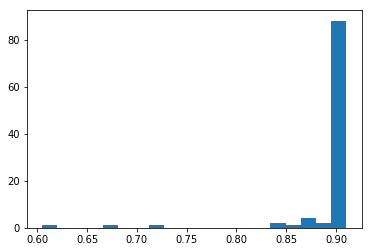

In [72]:
_ = plt.hist(A2, bins=20)

In [73]:
A3 = np.array([DPNaiveBayes(nurs, 20, HB_CM, next(s)) for x in range(0, 100)])

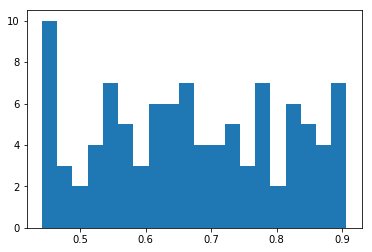

In [74]:
_ = plt.hist(A3, bins=20)

In [79]:
A4 = np.array([DPNaiveBayes(nurs, 20, cm, next(s)) for x in range(0, 100)])

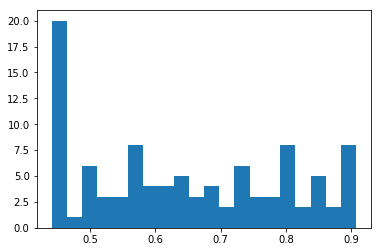

In [80]:
_ = plt.hist(A4, bins=20)

In [81]:
print(A1.mean())
print(A2.mean())
print(A3.mean())
print(A4.mean())

0.8548765432098766
0.895977366255144
0.6720833333333333
0.6477443415637859


In [95]:
import pickle
pickle.dump(cm.mf_eval, open('mf_eval.p', 'wb'))
pickle.dump(cm.alg_perfs, open('alg_perfs.p', 'wb'))